In [2]:
from tsai.models import MINIROCKET, HydraMultiRocketPlus, TST
from tsai.learner import ts_learner
from data_loader import DataLoader_HRI
from tsai.data.all import *
from tsai.models.utils import *
from tsai.all import my_setup, ShowGraphCallback2, LabelSmoothingCrossEntropyFlat, RocAucBinary, accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna.integration import WeightsAndBiasesCallback
import wandb
import json
import datetime
import platform
import numpy as np
from get_metrics import get_metrics


In [4]:
data_hri = DataLoader_HRI("../data/", verbose=True)

['0_val.csv', '0_train.csv', '1_val.csv', '1_train.csv', '2_val.csv', '2_train.csv', '3_train.csv', '3_val.csv', '4_train.csv', '4_val.csv', '5_train.csv', '5_val.csv', '6_val.csv', '6_train.csv', '7_train.csv', '7_val.csv', '8_train.csv', '8_val.csv', '9_val.csv', '9_train.csv', '10_val.csv', '10_train.csv', '11_train.csv', '11_val.csv', '12_val.csv', '12_train.csv', '13_val.csv', '13_train.csv', '14_train.csv', '14_val.csv', '15_train.csv', '15_val.csv', '16_train.csv', '17_train.csv', '18_train.csv', '19_train.csv', '20_train.csv', '21_train.csv', '22_train.csv', '23_train.csv', '24_train.csv', '25_train.csv', '26_train.csv', '27_train.csv', '28_train.csv', '29_train.csv', '30_train.csv', '31_train.csv', '32_train.csv', '33_train.csv', '34_train.csv', '35_train.csv', '36_train.csv', '37_train.csv', '38_train.csv', '39_train.csv', '40_train.csv', '41_train.csv', '42_train.csv', '43_train.csv', '44_train.csv', '45_train.csv', '46_train.csv', '47_train.csv', '48_train.csv', '49_train.c

In [ ]:
data_hri.train_X

NameError: name 'data_hri' is not defined

In [5]:
val_X_TS_list, val_Y_TS_list, train_X_TS, train_Y_TS, _ = data_hri.get_timeseries_format(
        intervallength=1000, stride_train=1000, fps=100, stride_eval=1000, verbose=True)

TS Processing for session:  0
TS Processing for session:  1
TS Processing for session:  2
TS Processing for session:  3
TS Processing for session:  4
TS Processing for session:  5
TS Processing for session:  6
TS Processing for session:  7
TS Processing for session:  8
TS Processing for session:  9
TS Processing for session:  10
TS Processing for session:  11
TS Processing for session:  12
TS Processing for session:  13
TS Processing for session:  14
TS Processing for session:  15
TS Processing for session:  16
TS Processing for session:  17
TS Processing for session:  18
TS Processing for session:  19
TS Processing for session:  20
TS Processing for session:  21
TS Processing for session:  22
TS Processing for session:  23
TS Processing for session:  24
TS Processing for session:  25
TS Processing for session:  26
TS Processing for session:  27
TS Processing for session:  28
TS Processing for session:  29
TS Processing for session:  30
TS Processing for session:  31
TS Processing for 

## Whats up with NaNs?

In [5]:
tr = data_hri.train_X
lenght = len(tr)
failed_cols=""
print(len(tr))
for col in tr.columns:
    if tr[col].isna().sum() == lenght:
        print(f"{col}: {tr[col].isna().sum()}!!!!!!")
        failed_cols += "'"+col+"',"
    else:
        print(f"{col}: {tr[col].isna().sum()}")
print(failed_cols)

764216
frame: 0
Unnamed: 0_speaker: 759456
session: 0
speaker_speaker: 759456
start_turn_speaker: 759456
end_turn_speaker: 759456
Loudness_sma3_opensmile: 759456
alphaRatio_sma3_opensmile: 759456
hammarbergIndex_sma3_opensmile: 759456
slope0-500_sma3_opensmile: 759456
slope500-1500_sma3_opensmile: 759456
spectralFlux_sma3_opensmile: 759456
mfcc1_sma3_opensmile: 759456
mfcc2_sma3_opensmile: 759456
mfcc3_sma3_opensmile: 759456
mfcc4_sma3_opensmile: 759456
F0semitoneFrom27.5Hz_sma3nz_opensmile: 759456
jitterLocal_sma3nz_opensmile: 759456
shimmerLocaldB_sma3nz_opensmile: 759456
HNRdBACF_sma3nz_opensmile: 759456
logRelF0-H1-H2_sma3nz_opensmile: 759456
logRelF0-H1-A3_sma3nz_opensmile: 759456
F1frequency_sma3nz_opensmile: 759456
F1bandwidth_sma3nz_opensmile: 759456
F1amplitudeLogRelF0_sma3nz_opensmile: 759456
F2frequency_sma3nz_opensmile: 759456
F2bandwidth_sma3nz_opensmile: 759456
F2amplitudeLogRelF0_sma3nz_opensmile: 759456
F3frequency_sma3nz_opensmile: 759456
F3bandwidth_sma3nz_opensmile: 

In [10]:
tr[tr["session"]==8].head(50)

,frame,Unnamed: 0_speaker,session,speaker_speaker,start_turn_speaker,end_turn_speaker,Loudness_sma3_opensmile,alphaRatio_sma3_opensmile,hammarbergIndex_sma3_opensmile,slope0-500_sma3_opensmile,...,dist_7_1_openpose,vel_dist_7_1_openpose,dist_7_17_openpose,vel_dist_7_17_openpose,dist_7_15_openpose,vel_dist_7_15_openpose,dist_7_18_openpose,vel_dist_7_18_openpose,dist_7_16_openpose,vel_dist_7_16_openpose
0,1,0.0,8,robot,0.767813,11.145938,0.014233,-9.592065,21.979767,-0.020077,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
1,1,1.0,8,pause,11.145938,12.074063,0.018140,-8.504927,22.437357,0.004125,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
2,1,2.0,8,participant,12.074063,13.137187,0.023023,-7.660947,21.587626,0.011009,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
3,1,3.0,8,pause,13.137187,17.355937,0.026752,-8.234418,23.160614,0.001526,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
4,2,4.0,8,robot,17.355937,58.547812,0.029027,-9.538793,24.118265,-0.021656,...,333.378430,2.477415,506.907573,0.004634,524.353165,0.002031,459.014747,-0.015021,506.172747,-0.001273
5,2,5.0,8,pause,58.547812,59.948437,0.029896,-11.566297,27.326468,-0.018944,...,333.378430,2.477415,506.907573,0.004634,524.353165,0.002031,459.014747,-0.015021,506.172747,-0.001273
6,2,6.0,8,participant,59.948437,60.522188,0.029909,-12.432727,28.618395,-0.016866,...,333.378430,2.477415,506.907573,0.004634,524.353165,0.002031,459.014747,-0.015021,506.172747,-0.001273
7,3,7.0,8,pause,60.522188,64.572187,0.029591,-12.973359,29.418625,-0.018288,...,330.901015,-2.323766,506.902939,-2.406557,524.351135,-2.536278,459.029768,-2.650161,506.174020,-2.610047
8,3,8.0,8,robot,64.572187,71.997187,0.029714,-12.576275,29.626717,-0.028575,...,330.901015,-2.323766,506.902939,-2.406557,524.351135,-2.536278,459.029768,-2.650161,506.174020,-2.610047
9,3,9.0,8,pause,71.997187,80.451562,0.029913,-12.001461,29.547945,-0.024144,...,330.901015,-2.323766,506.902939,-2.406557,524.351135,-2.536278,459.029768,-2.650161,506.174020,-2.610047


In [12]:
tr[tr["session"]==8]

,frame_opensmile,robot_speaker,session,participant_speaker,pause_speaker,Loudness_sma3_opensmile,alphaRatio_sma3_opensmile,hammarbergIndex_sma3_opensmile,slope0-500_sma3_opensmile,slope500-1500_sma3_opensmile,...,dist_7_1_openpose,vel_dist_7_1_openpose,dist_7_17_openpose,vel_dist_7_17_openpose,dist_7_15_openpose,vel_dist_7_15_openpose,dist_7_18_openpose,vel_dist_7_18_openpose,dist_7_16_openpose,vel_dist_7_16_openpose
0,NaN,0.0,8,0.0,1.0,0.014233,-9.592065,21.979767,-0.020077,0.033826,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
1,NaN,0.0,8,0.0,1.0,0.018140,-8.504927,22.437357,0.004125,0.030856,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
2,NaN,0.0,8,0.0,1.0,0.023023,-7.660947,21.587626,0.011009,0.029848,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
3,NaN,0.0,8,0.0,1.0,0.026752,-8.234418,23.160614,0.001526,0.028589,...,330.907961,-2.470469,506.895125,-0.012449,524.327479,-0.025686,458.998121,-0.016627,506.146684,-0.026063
4,NaN,0.0,8,0.0,1.0,0.029027,-9.538793,24.118265,-0.021656,0.033912,...,333.378430,2.477415,506.907573,0.004634,524.353165,0.002031,459.014747,-0.015021,506.172747,-0.001273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74097,NaN,0.0,8,0.0,1.0,0.029421,-12.549987,28.131899,-0.017695,0.037016,...,343.724125,-0.012438,516.030104,-2.510066,530.209677,-0.001256,477.412483,-0.018339,518.920870,0.002837
74098,NaN,0.0,8,0.0,1.0,0.030341,-13.446575,26.750702,-0.027437,0.036140,...,343.724125,-0.012438,516.030104,-2.510066,530.209677,-0.001256,477.412483,-0.018339,518.920870,0.002837
74099,NaN,0.0,8,0.0,1.0,0.029202,-13.395779,28.787650,-0.031874,0.038891,...,343.724125,-0.012438,516.030104,-2.510066,530.209677,-0.001256,477.412483,-0.018339,518.920870,0.002837
74100,NaN,NaN,8,NaN,NaN,0.029302,-12.954009,28.949830,-0.023990,0.043437,...,343.724125,-0.012438,516.030104,-2.510066,530.209677,-0.001256,477.412483,-0.018339,518.920870,0.002837


In [12]:
# why do the rest of the openpose columns have so many NaNs?
for session in (tr["session"].unique()):
    print(f"Session {session}")
    print(tr[tr["session"]==session]["frame_opensmile"].isna().sum())


Session 0
8
Session 1
8
Session 2
9
Session 3
9
Session 4
8
Session 5
8
Session 6
8
Session 7
14
Session 8
74102
Session 9
52604
Session 10
5
Session 11
3
Session 12
3
Session 13
2
Session 14
8
Session 15
7
Session 16
9
Session 17
9
Session 18
7
Session 19
7
Session 20
8
Session 21
8
Session 22
8
Session 23
4
Session 24
3
Session 25
4
Session 26
5
Session 27
3
Session 28
53807
Session 29
3
Session 30
8
Session 31
7
Session 32
7
Session 33
7
Session 34
9
Session 35
7
Session 36
64706
Session 37
41704
Session 38
4
Session 39
4
Session 40
4
Session 41
2
Session 42
40502
Session 43
8
Session 44
7
Session 45
13
Session 46
52701
Session 47
1
Session 48
40303
Session 49
2
Session 50
70504
Session 51
3
Session 52
4
Session 53
5
Session 54
3


In [ ]:
# print lenght of each each session in the dataset (per dataframe)

train_Y_counts = data_hri.train_Y["session"].value_counts().sort_index()
train_X_counts = data_hri.train_X["session"].value_counts().sort_index()
val_Y_counts = data_hri.val_Y["session"].value_counts().sort_index()
val_X_counts = data_hri.val_X["session"].value_counts().sort_index()

# print side by side
print("Train")
print(pd.concat([train_Y_counts, train_X_counts], axis=1))
print("Val")
print(pd.concat([val_Y_counts, val_X_counts], axis=1))


Train
         count  count
session              
0        46109  46103
1        51709  51702
2        83206  83200
3        50708  50700
4        54205  54199
5        50909  50902
6        40605  40599
7        52317  52303
8        74100  74102
9        52600  52604
10       32000  31132
11       38300  37708
12       36600  36344
13       40700  40487
14       35613  35605
15       43011  43004
16       48305  48298
17       38411  38402
18       50806  50800
19       37609  37602
20       29911  29903
21       39108  39101
22       51709  51702
23       40300  40298
24       38300  37670
25       41600  40992
26       36400  35650
27       30600  30278
28       53800  53807
29       34200  34199
30       51108  51102
31       37014  37007
32       46614  46607
33       56611  56604
34       33105  33098
35       39811  39804
36       64700  64706
37       41700  41704
38       31500  30836
39       43400  43098
40       35800  35227
41       34700  34188
42       40500  40502
43  

In [6]:
print(data_hri.val_Y["InteractionRupture"].value_counts(normalize=True))
print(data_hri.val_Y["RobotMistake"].value_counts(normalize=True))
print(data_hri.val_Y["UserAwkwardness"].value_counts(normalize=True))

InteractionRupture
0    0.762573
1    0.237427
Name: proportion, dtype: float64
RobotMistake
0    0.854997
1    0.145003
Name: proportion, dtype: float64
UserAwkwardness
0    0.827341
1    0.172659
Name: proportion, dtype: float64


In [ ]:
# look at correlations

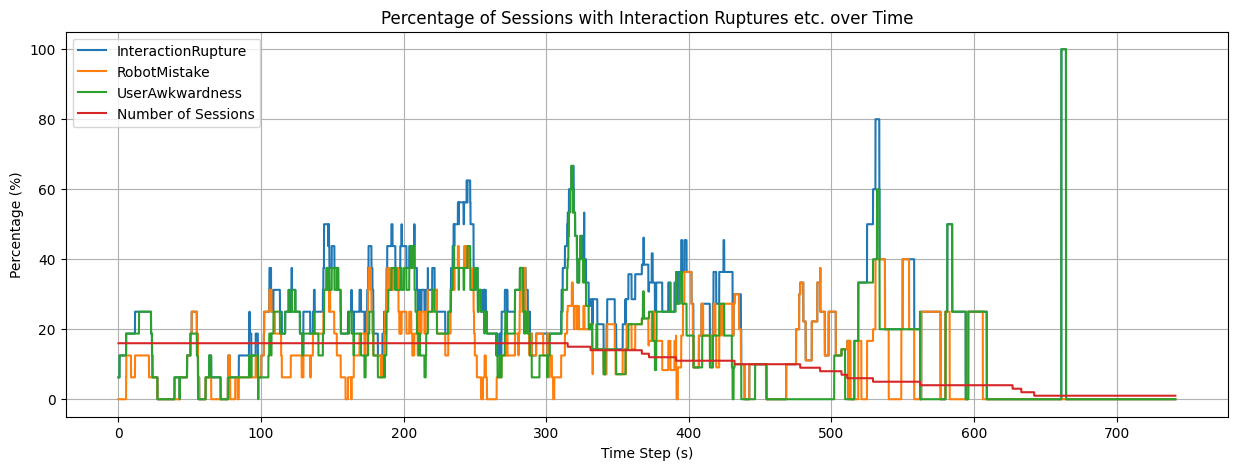

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# I'll assume 'data_hri' is already loaded and properly formatted.
# You should have the following:
# data_hri.val_Y -- a DataFrame with at least columns 'session' and 'InteractionRupture'.

# First, let's create a DataFrame to hold the percentage of InteractionRupture==1 per time step.
# This assumes that there's a 'time' or similar column in your DataFrame to group by.

# Extract unique session IDs and time steps
unique_sessions = data_hri.val_Y['session'].unique()
unique_time_steps = sorted(data_hri.val_Y['frame'].unique())  # Assuming a 'time' column exists

# Initialize an array to hold the percentage of InteractionRupture == 1 per time step
rupture_percentages = []
rupture_percentages_robot = []
rupture_percentages_user = []
number_of_sessions = []

# Calculate the percentage for each time step
for time_step in unique_time_steps:
    # Get all entries for this time step
    time_step_data = data_hri.val_Y[data_hri.val_Y['frame'] == time_step]
    # Calculate the percentage of InteractionRupture == 1
    percentage = 100 * (time_step_data['InteractionRupture'] == 1).mean()
    rupture_percentages.append(percentage)
    percentage_robot = 100 * (time_step_data['RobotMistake'] == 1).mean()
    rupture_percentages_robot.append(percentage_robot)
    percentage_user = 100 * (time_step_data['UserAwkwardness'] == 1).mean()
    rupture_percentages_user.append(percentage_user)
    number_of_sessions.append(len(time_step_data['session'].unique()))

# timestep to seconds
unique_time_steps = [x/100 for x in unique_time_steps]


# Plotting
plt.figure(figsize=(15, 5))
plt.plot(unique_time_steps, rupture_percentages, label='InteractionRupture')
plt.plot(unique_time_steps, rupture_percentages_robot, label='RobotMistake')
plt.plot(unique_time_steps, rupture_percentages_user, label='UserAwkwardness')
plt.plot(unique_time_steps, number_of_sessions, label='Number of Sessions')
plt.title('Percentage of Validation Sessions with Interaction Ruptures etc. over Time')
plt.xlabel('Time Step (s)')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.legend()
plt.show()

